# Style transfer using pretrained VGG19

In this notebook we perform style trasfer as described in [Image Style Transfer Using Convolutional Neural Networks](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Gatys_Image_Style_Transfer_CVPR_2016_paper.pdf) i.e. with pretrained VGG19 convolutional neural network. The idea is to transfer style from one image (e.g. artwork) into another, preserving content of the latter. The result depends on layers which we choose to represent the content image and the style image. Later on, we define and calculate the loss function which we try to minimize (see orignal paper for details).

We adapt most of the code from [Udacity course](https://github.com/udacity/deep-learning-v2-pytorch/tree/master/style-transfer).

In [1]:
import helper_functions

import torch
from torch import optim

import matplotlib.pyplot as plt
import numpy as np
import datetime
import os

%matplotlib inline

# use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# load model with default parameters
model = helper_functions.load_vgg19().to(device)

In [3]:
# load content and style images with the same size
content = helper_functions.load_image('img/sunrise.jpg').to(device)
style = helper_functions.load_image('img/monet.jpg', shape=content.shape[-2:]).to(device)

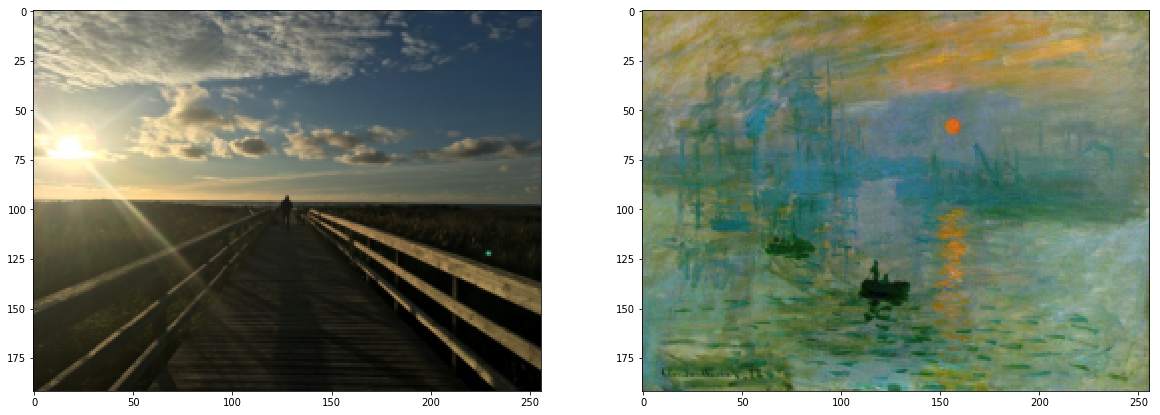

In [4]:
# display resized images
fix, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(helper_functions.convert_image(content))
ax2.imshow(helper_functions.convert_image(style))

In [5]:
# extract all layer names
layer_names = helper_functions.get_layer_names(model)

# get features for content and style images
content_features = helper_functions.get_features(content, model, layer_names)
style_features = helper_functions.get_features(style, model, layer_names)

# calculate gram matrices for style image - we will use it later for loss calculation
style_grams = {layer : helper_functions.gram_matrix(style_features[layer]) for layer in style_features}

### Filters activation

Let us now display how individual filters are activated by our content and style images. For concretness, we will show only those filters that exhibit minimal and maximal activations (related here to the mean of a given feature array). 

D:\Programy\Miniconda3\envs\torch\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


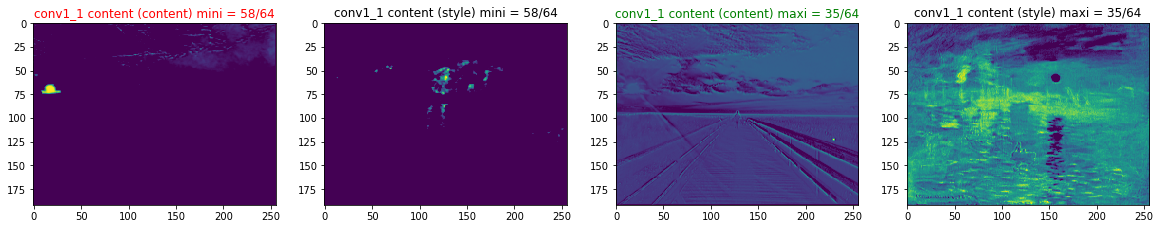

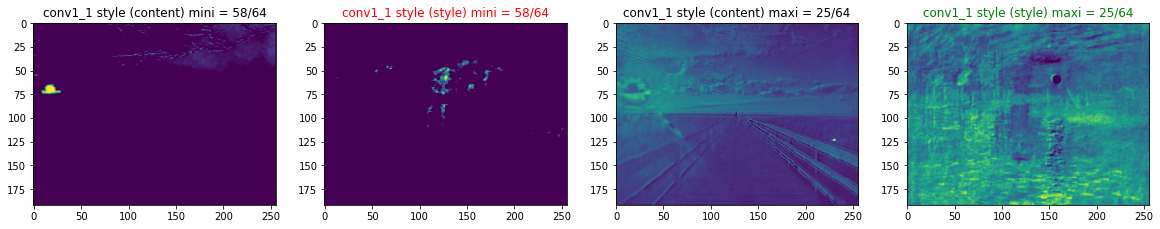

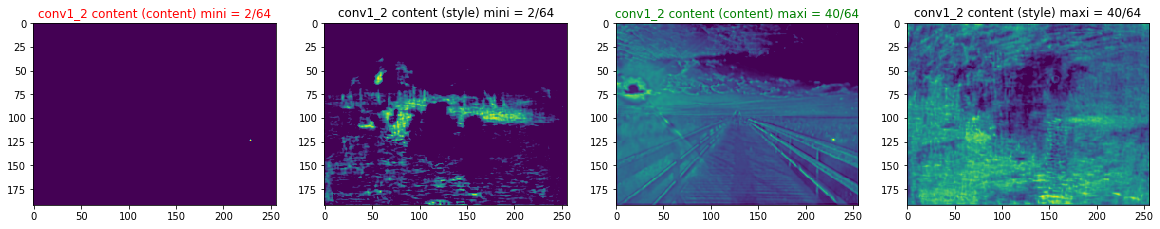

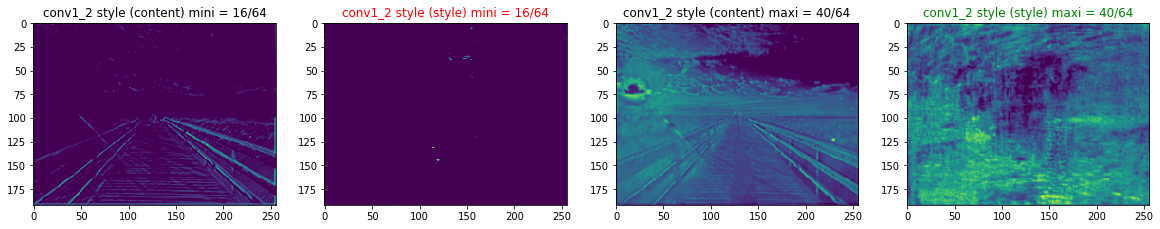

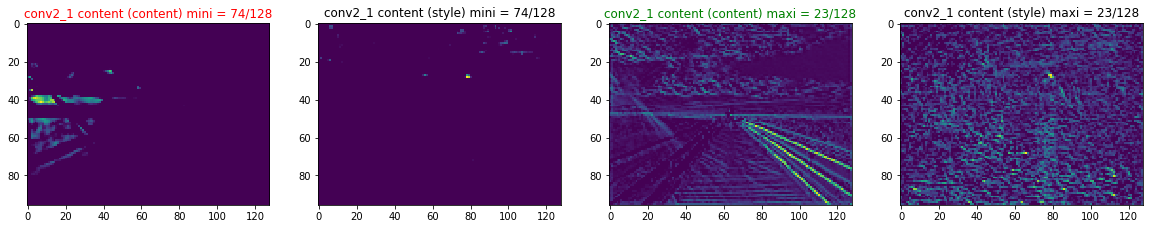

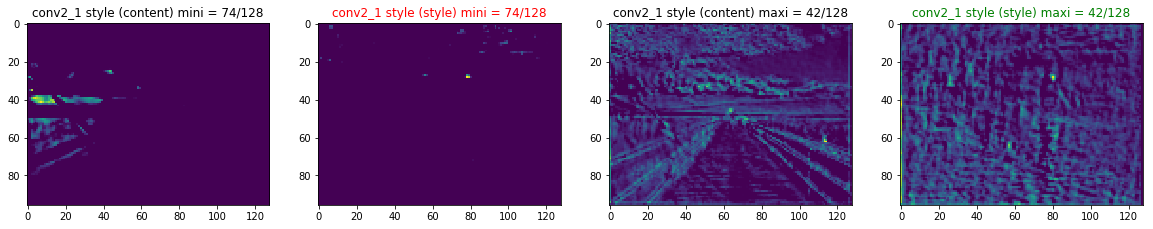

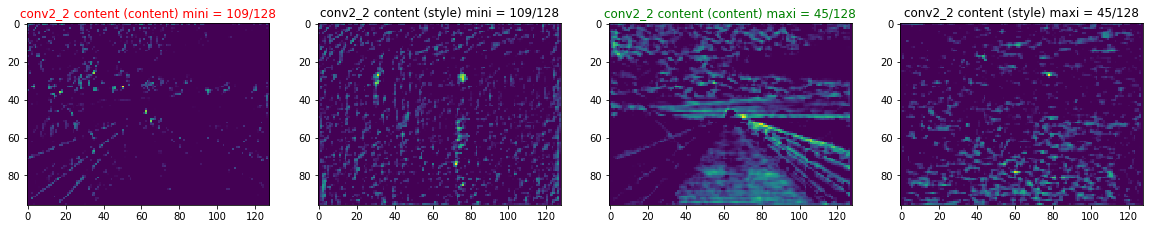

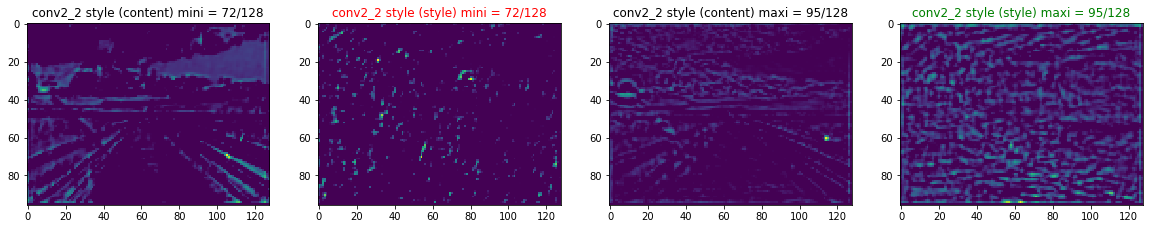

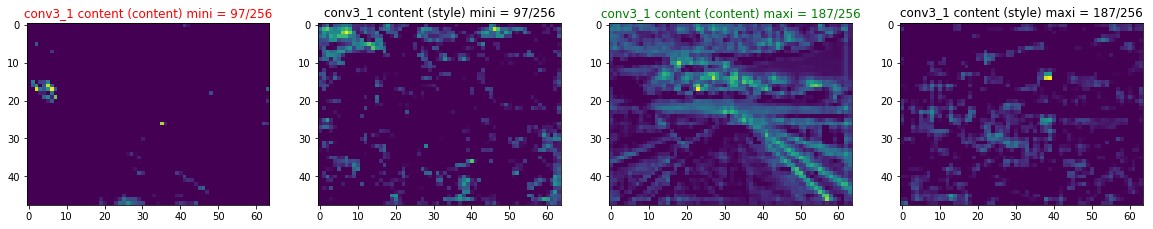

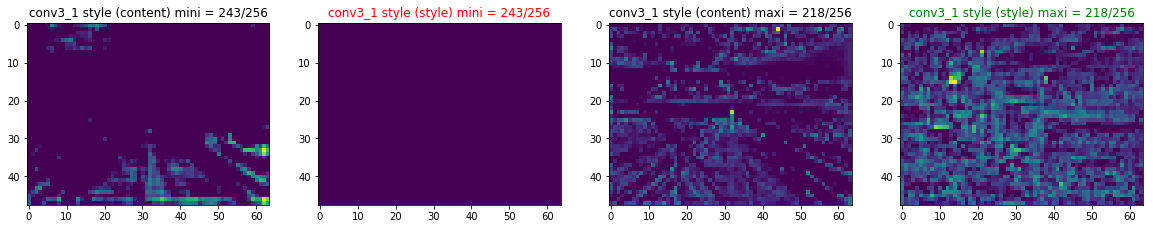

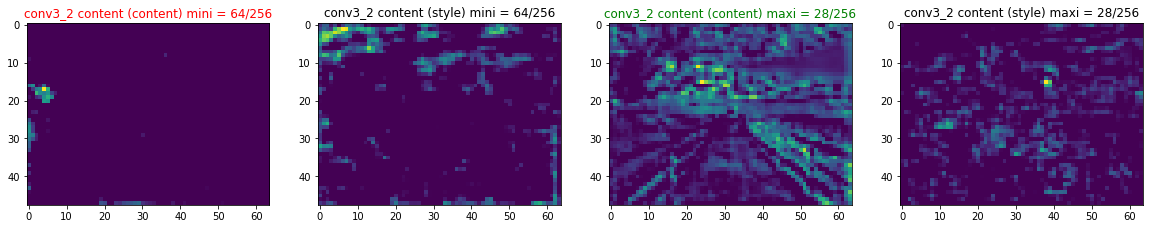

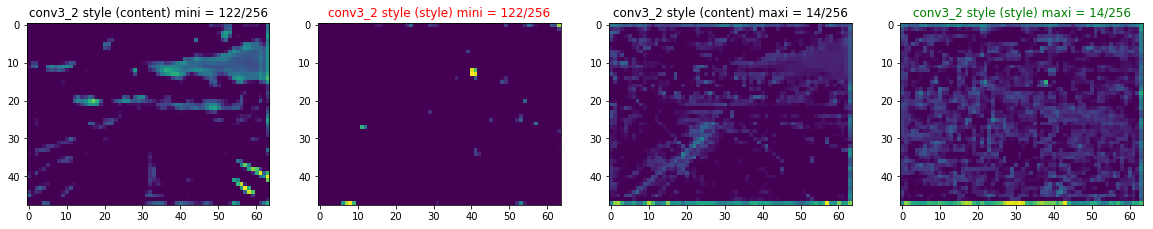

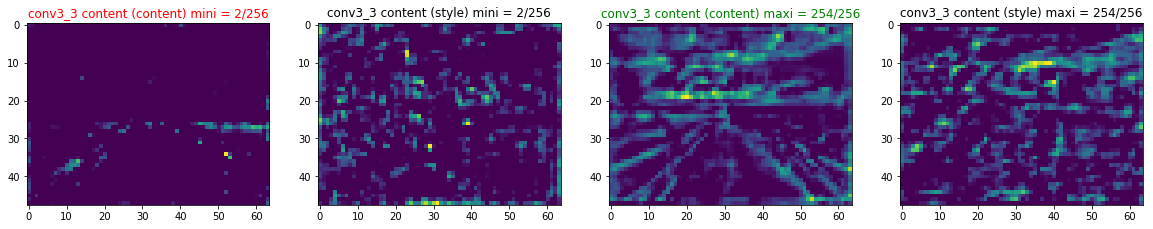

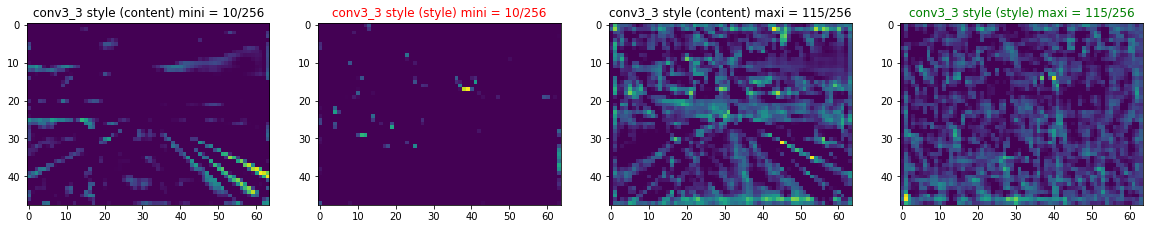

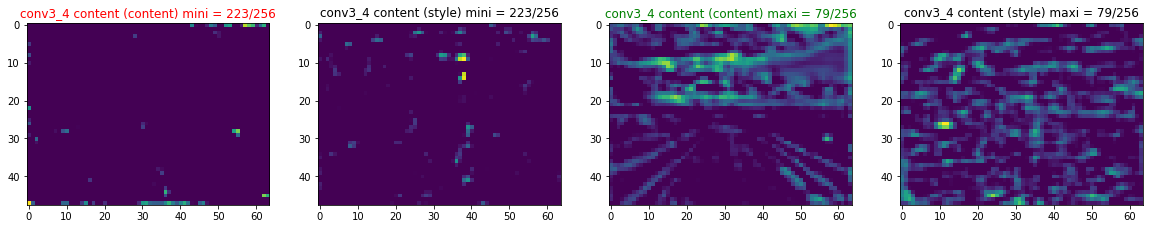

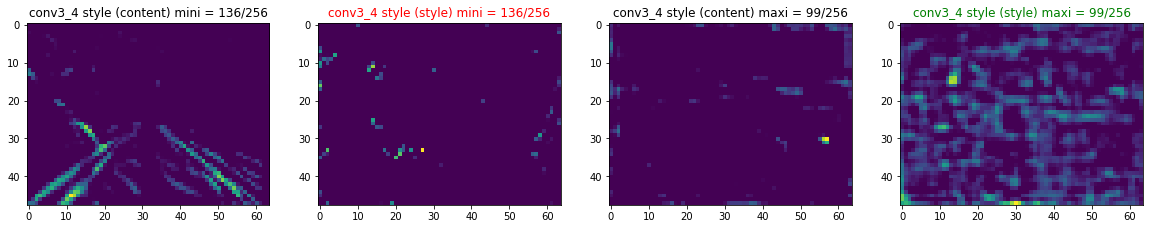

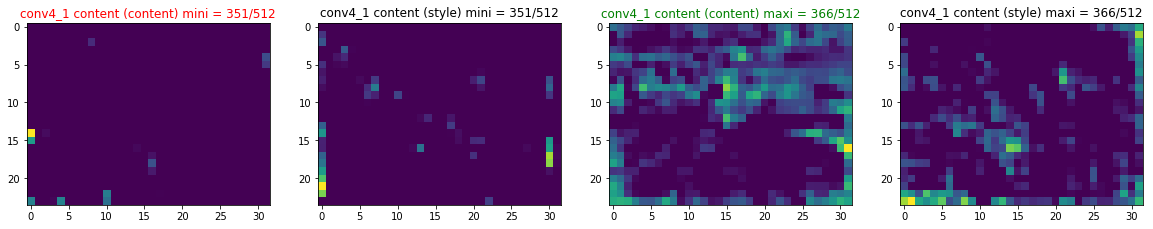

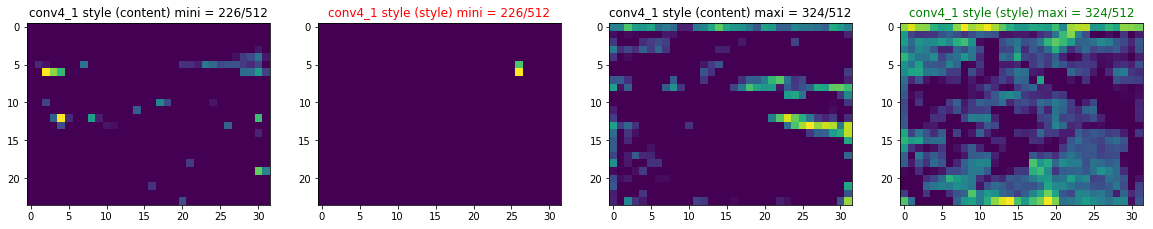

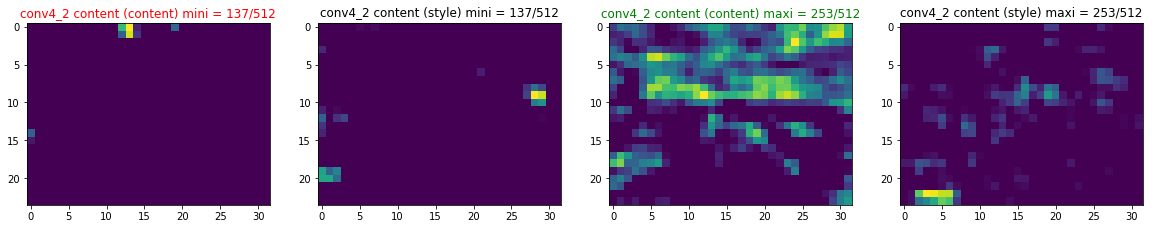

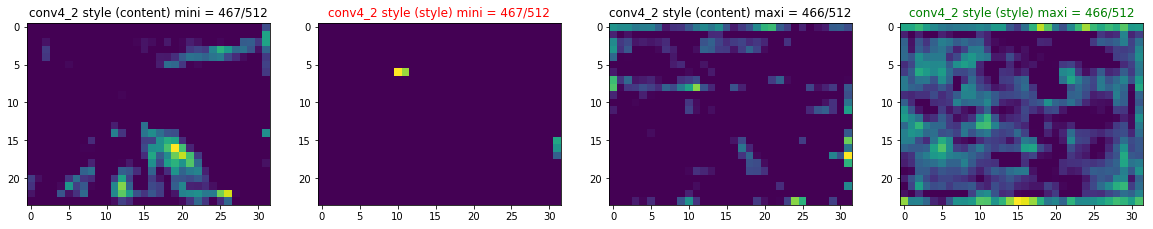

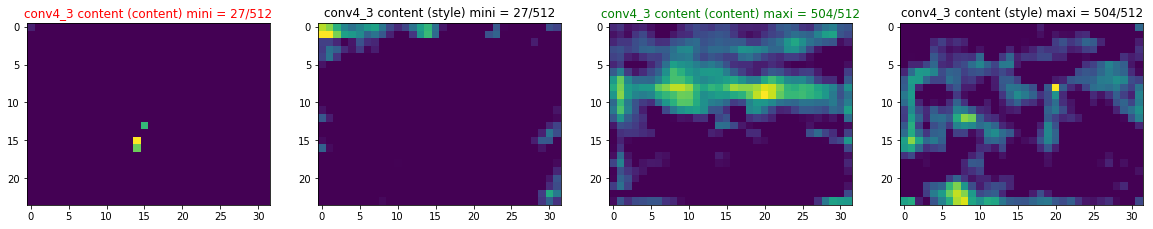

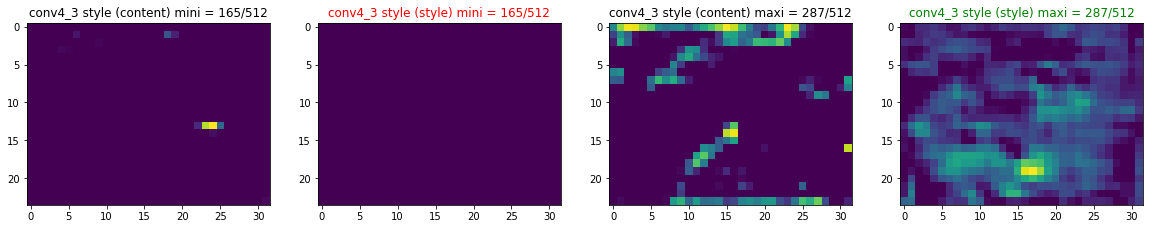

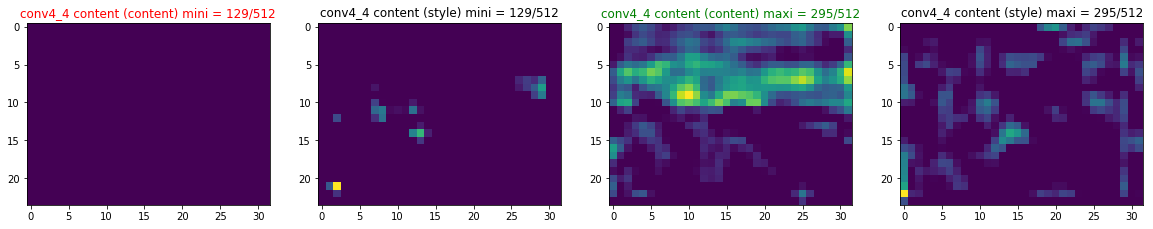

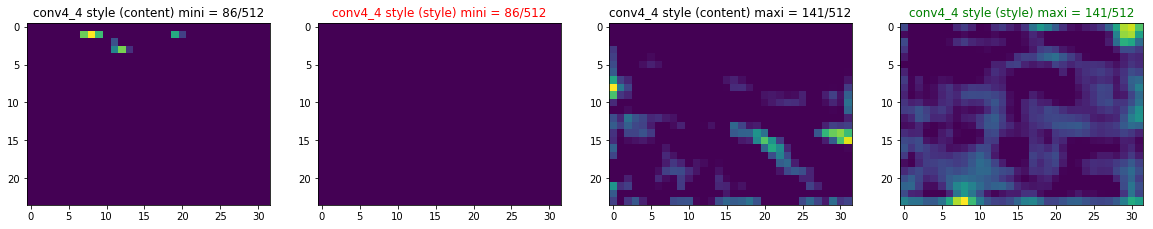

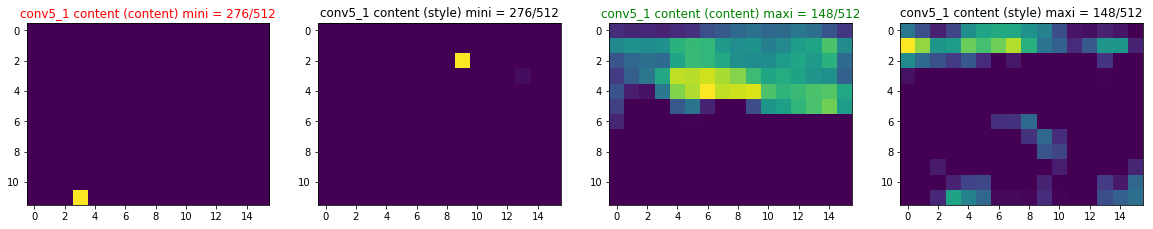

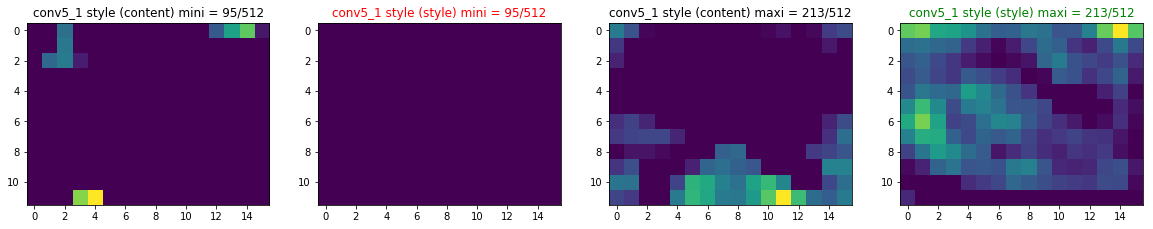

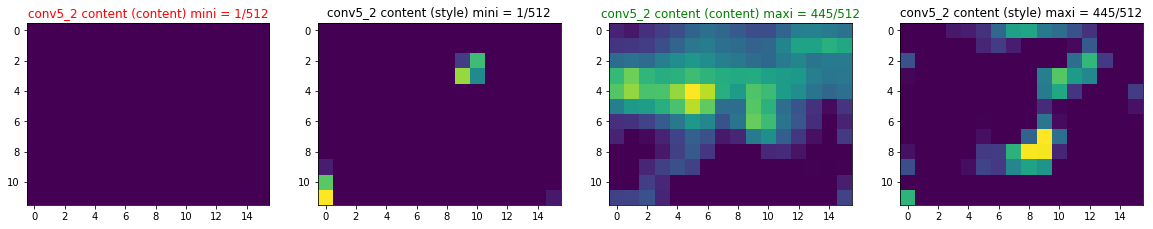

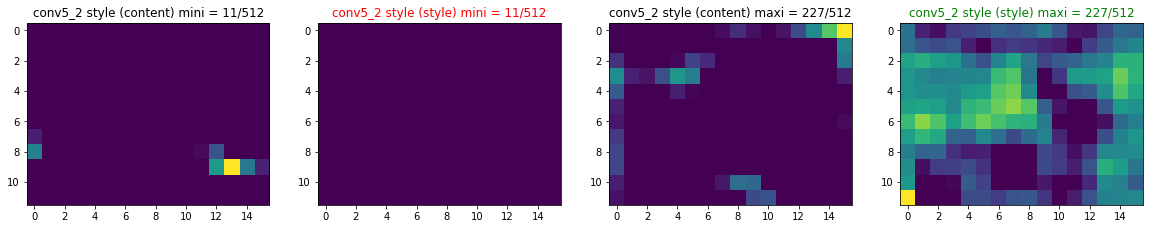

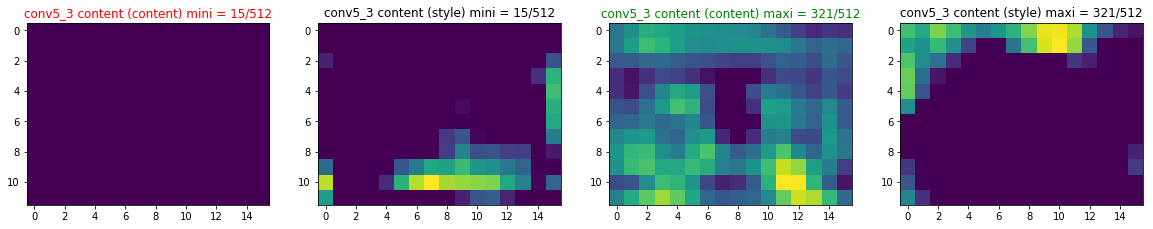

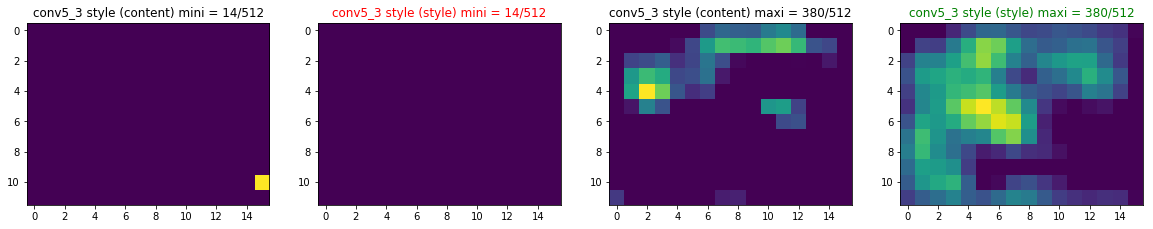

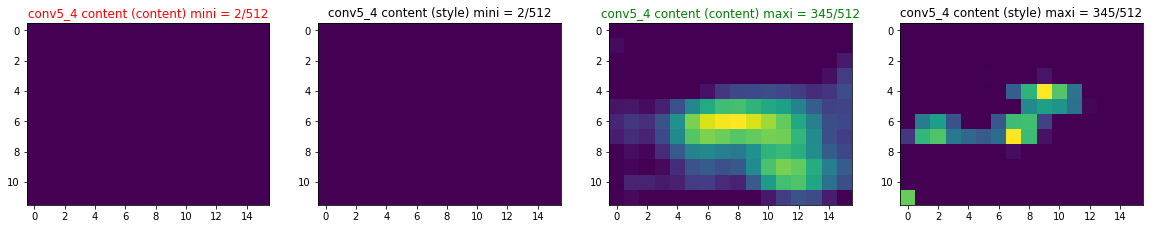

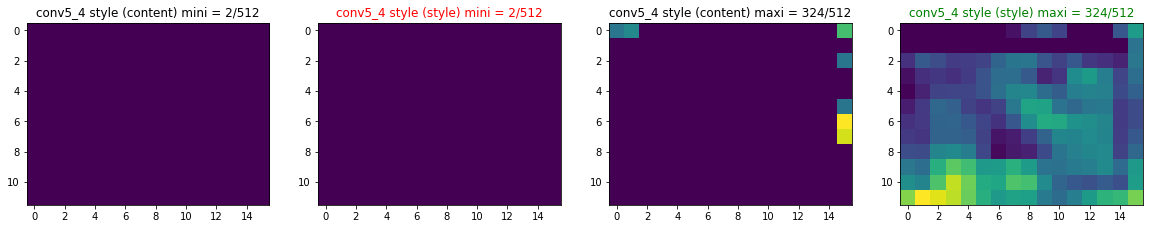

In [6]:
for _, name in layer_names.items():
    
    content_tensor = content_features[name].squeeze(0).numpy()
    style_tensor = style_features[name].squeeze(0).numpy()
    
    for type, tensor in zip(['content', 'style'], [content_tensor, style_tensor]):
        mean_array = np.mean(tensor, axis=(1,2))
        mini, maxi = np.argmin(mean_array), np.argmax(mean_array)
        
        # display minimal and maximal activations for content image (even rows, 1 and 3 column)
        # and style image (odd rows, 2 and 4 column) - red and green captions
        # show also activations of style image for filters that exhibit
        # minimal and maximal activation of conent image and vice versa - black captions
        fix, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 10))
        ax1.imshow(content_tensor[mini])
        ax2.imshow(style_tensor[mini])
        ax3.imshow(content_tensor[maxi])
        ax4.imshow(style_tensor[maxi])

        color = 'r' if type == 'content' else 'k'
        ax1.set_title(name + ' ' + type + ' (content) mini = ' + str(mini+1)+ '/' + str(mean_array.shape[0]), color=color)
        color = 'r' if type == 'style' else 'k'
        ax2.set_title(name + ' ' + type + ' (style) mini = ' + str(mini+1)+ '/' + str(mean_array.shape[0]), color=color)
        color = 'g' if type == 'content' else 'k'
        ax3.set_title(name + ' ' + type + ' (content) maxi = ' + str(maxi+1)+ '/' + str(mean_array.shape[0]), color=color)
        color = 'g' if type == 'style' else 'k'
        ax4.set_title(name + ' ' + type + ' (style) maxi = ' + str(maxi+1)+ '/' + str(mean_array.shape[0]), color=color)

**Note:** from the above plots, it is rather hard to conclude which layers are good candidates for content and style representations. We can however see how the activation strength changes through the neural network.

### Parameters initialization

Below we gather all parameters which heavily influence the result (target image).  

In [7]:
target_start_type = 'content' # specify of which (content or style) image to start

content_layer_name = 'conv4_2' # layer name for content image representation

# layer names and weights for style image representation
style_weights = {
    'conv1_1' : 1.,
    'conv2_1' : 0.75,
    'conv3_1' : 0.5,
    'conv4_1' : 0.2,
    'conv5_1' : 0.2,    
}

style_to_content_weight = 1e5 # style to content weight ratio (beta/alpha)

# target image initialization
target = content.clone() if target_start_type == 'content' else style.clone()
target = target.requires_grad_(True).to(device)

lr = 0.01 # learning rate
optimizer = optim.Adam([target], lr=lr) # optimizer

### Calculation

Now it is time to define the main function that processes the target image and check how the model works. 

In [8]:
def process_image(target, content_layer_name, style_weights, style_to_content_weight, lr, optimizer, show_every=500, steps=3000):
    '''Function that process the target image for a given input and style images.
       Note that all the rest parameters must be declared as global'''

    # Create directory for output images
    curr_time = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S.%f')
    dirname = 'session__' + curr_time
    os.mkdir(dirname)
    
    # Save parameter values
    with open(dirname + '/params.dat', 'w+') as f:
        f.write('content_layer_name: ' + str(content_layer_name) + '\n')
        f.write('style_weights: ' + str(style_weights) + '\n')
        f.write('style_to_content_weight: ' + str(style_to_content_weight) + '\n')
        f.write('lr: ' + str(lr) + '\n')
        f.write('optimizer: ' + str(optimizer) + '\n')
        f.write('steps: ' + str(steps) + '\n')
    
    # Save rescaled content and style images
    helper_functions.save_tensor_as_image(content, dirname + '/content.jpg')
    helper_functions.save_tensor_as_image(style, dirname + '/style.jpg')  
        
    for i in range(1, steps+1):
        
        if i % 10 == 0:
            print(i, end=' ')

        target_features = helper_functions.get_features(target, model, layer_names)

        # content loss
        content_loss = torch.mean((target_features[content_layer_name] - content_features[content_layer_name])**2)

        # style loss
        style_loss = 0
        for layer in style_weights:

            target_feature = target_features[layer]
            target_gram = helper_functions.gram_matrix(target_feature)
            style_gram = style_grams[layer]
            _, _, h, w = target_feature.shape # we need only two last dimensions

            layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
            style_loss += layer_style_loss / (h * w)**2 # normalization as in Gatys et al (2016)

        style_loss *= style_to_content_weight
        target_loss = content_loss + style_loss
        # Gradient calculation
        optimizer.zero_grad()
        target_loss.backward()
        # Target image update
        optimizer.step()

        if i % show_every == 0:
            print("\nTotal loss (content / style) = {:.2f} ({:.2f} / {:.2f})".format(target_loss, content_loss, style_loss))
            plt.imshow(helper_functions.convert_image(target))
            plt.show()
            helper_functions.save_tensor_as_image(target, dirname + '/target_after_' + str(i) + '.jpg')
            print('File saved...')

    # Save start and end times
    with open(dirname + '/params.dat', 'a') as f:
        f.write('Start time: ' + curr_time)
        curr_time = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S.%f')
        f.write('\nEnd time: ' + curr_time)      

10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 370 380 390 400 410 420 430 440 450 460 470 480 490 500 
Total loss (content / style) = 2336.54 (7.41 / 2329.13)


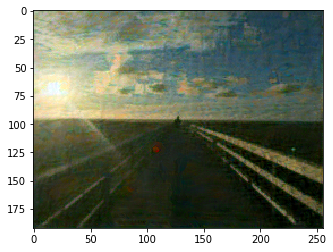

File saved...
510 520 530 540 550 560 570 580 590 600 610 620 630 640 650 660 670 680 690 700 710 720 730 740 750 760 770 780 790 800 810 820 830 840 850 860 870 880 890 900 910 920 930 940 950 960 970 980 990 1000 
Total loss (content / style) = 1409.38 (7.66 / 1401.72)


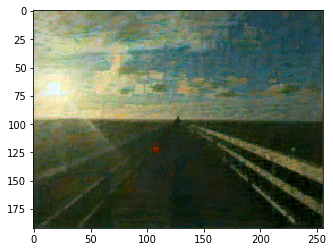

File saved...
1010 1020 1030 1040 1050 1060 1070 1080 1090 1100 1110 1120 1130 1140 1150 1160 1170 1180 1190 1200 1210 1220 1230 1240 1250 1260 1270 1280 1290 1300 1310 1320 1330 1340 1350 1360 1370 1380 1390 1400 1410 1420 1430 1440 1450 1460 1470 1480 1490 1500 
Total loss (content / style) = 1060.38 (7.76 / 1052.63)


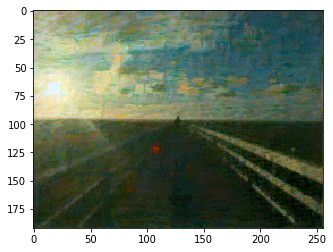

File saved...
1510 1520 1530 1540 1550 1560 1570 1580 1590 1600 1610 1620 1630 1640 1650 1660 1670 1680 1690 1700 1710 1720 1730 1740 1750 1760 1770 1780 1790 1800 1810 1820 1830 1840 1850 1860 1870 1880 1890 1900 1910 1920 1930 1940 1950 1960 1970 1980 1990 2000 
Total loss (content / style) = 854.80 (7.86 / 846.93)


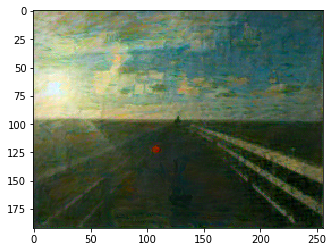

File saved...
2010 2020 2030 2040 2050 2060 2070 2080 2090 2100 2110 2120 2130 2140 2150 2160 2170 2180 2190 2200 2210 2220 2230 2240 2250 2260 2270 2280 2290 2300 2310 2320 2330 2340 2350 2360 2370 2380 2390 2400 2410 2420 2430 2440 2450 2460 2470 2480 2490 2500 
Total loss (content / style) = 730.68 (7.92 / 722.75)


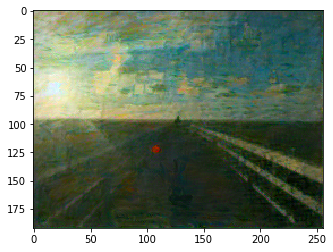

File saved...
2510 2520 2530 2540 2550 2560 2570 2580 2590 2600 2610 2620 2630 2640 2650 2660 2670 2680 2690 2700 2710 2720 2730 2740 2750 2760 2770 2780 2790 2800 2810 2820 2830 2840 2850 2860 2870 2880 2890 2900 2910 2920 2930 2940 2950 2960 2970 2980 2990 3000 
Total loss (content / style) = 640.66 (7.96 / 632.70)


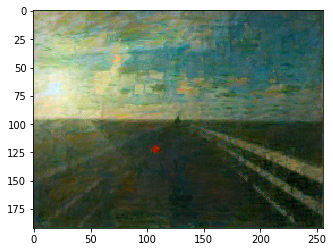

File saved...


In [9]:
process_image(target, content_layer_name, style_weights, 
              style_to_content_weight, lr, optimizer, 500, 3000)